Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Tensorflow Similarity with Kaggle

[Google Landmark Retrieval 2021](https://www.kaggle.com/c/landmark-retrieval-2021/overview): Given an image, can you find all of the same landmarks in a dataset?

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

## Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to train a `SimilarityModel()` for a Kaggle competition and will. 

 1. Show how to efficiently load the Kaggle data from disk.
 
 1. `train()` a similarity model.

 2. `index()` the /index examples.

 3. `calibrate()` the model to estimate what is the best distance theshold to separate matching elements from elements belonging to other classes.

 5. Generate the submission file.

In [1]:
import csv
import os
import random
import time
from collections import defaultdict
from multiprocessing import Pool, cpu_count
from pathlib import Path

import IPython.display as display
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
from tabulate import tabulate
from tqdm.auto import tqdm

In [2]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity -q
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [3]:
from tensorflow_similarity.architectures import EfficientNetSim
from tensorflow_similarity.augmenters import RandAugment
from tensorflow_similarity.losses import MultiSimilarityLoss, TripletLoss
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

In [4]:
tf.get_logger().setLevel("ERROR")  # silence TF warning
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # silence remaining TF warnings
tfsim.utils.tf_cap_memory()

In [5]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)
print(tf.config.list_physical_devices())

TensorFlow: 2.6.0
TensorFlow Similarity 0.15.0.dev36
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [6]:
import gc

gc.collect()
tf.keras.backend.clear_session()

# Basic Data Info

In [7]:
data_path = Path("../../../kaggle_ds/google_landmarks")

              count
count  81313.000000
mean      19.436867
std       42.877489
min        2.000000
25%        5.000000
50%        9.000000
75%       20.000000
max     6272.000000

Total number of unique images in the dataset: 1580470

Number of train classes with more than 4 images: 64988
Number of train images for the subset of classes: 1388362

Number of validation classes with more than 4 images: 7242
Number of validation images for the subset of classes: 160510

Number of test classes with 100 images: 92
Number of test images for the subset of classes: 9375



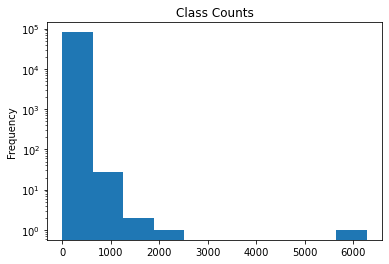

In [8]:
class_counts = defaultdict(int)
TOTAL_NUM_IMAGES = 0

with open(data_path / "train.csv") as csvfile:
    # pathlib is slow while looping
    data_path_str = str(data_path)

    # reader is faster than DictReader
    reader = csv.reader(csvfile)
    next(reader)  # drop the header

    for row in reader:
        # add img either in validation or testing
        class_counts[int(row[1])] += 1
        TOTAL_NUM_IMAGES += 1

df = pd.DataFrame({"class": class_counts.keys(), "count": class_counts.values()})
df["count"].plot(kind="hist", logy=True, title="Class Counts")
print(df[["count"]].describe())
print()

# Used for testing index MAP@100
test_filter = (df["count"] >= 101) & (df["count"] <= 103)
test_class_ids = set(df.loc[test_filter, "class"].values)
NUM_TEST_IMGS = df.loc[test_filter, "count"].sum()

train_validation_filter = (df["count"] >= 4) & ~test_filter
train_class_ids = set()
validation_class_ids = set()
validation_data_pctg = 10
for cid in df.loc[train_validation_filter, "class"].values:
    if  hash(str(cid)) % 100 >= validation_data_pctg:
        train_class_ids.add(cid)
    else:
        validation_class_ids.add(cid)
        

NUM_TRAIN_IMGS = df.loc[df["class"].isin(train_class_ids), "count"].sum()
NUM_VALIDATION_IMGS = df.loc[df["class"].isin(validation_class_ids), "count"].sum()

print(f"Total number of unique images in the dataset: {TOTAL_NUM_IMAGES}")
print()
print(f"Number of train classes with more than 4 images: {len(train_class_ids)}")
print(f"Number of train images for the subset of classes: {NUM_TRAIN_IMGS}")
print()
print(
    f"Number of validation classes with more than 4 images: {len(validation_class_ids)}"
)
print(f"Number of validation images for the subset of classes: {NUM_VALIDATION_IMGS}")
print()
print(
    f"Number of test classes with 100 images: {len(test_class_ids)}"
)
print(f"Number of test images for the subset of classes: {NUM_TEST_IMGS}")
print()

# Functions and variables

In [9]:
IMG_SIZE = 224  # based on the EfficientNet varient. Here we use 'B4'
LARGER_IMG_SIZE = int(IMG_SIZE * 1.2)  # Increased image size used for resize and crop.
CLASSES_PER_BATCH = 128  # batch size = CLASSES_PER_BATCH* 2
NUM_TRAIN_LANDMARKS = len(train_class_ids)
NUM_VALIDATION_LANDMARKS = len(validation_class_ids)
NUM_TEST_LANDMARKS = len(test_class_ids)

CPU_COUNT = cpu_count()
print("NUM CPU:", CPU_COUNT)

NUM CPU: 32


# Data preparation

The following section loads the test data into index and query splits as np.arrays. This will be used later to calibrate and test the model.

NOTE: these data sets are large and the following cells have been optimized to improve the loading speed.

In [10]:
x_test_img_path, y_test = [], []
train_data = defaultdict(list)
validation_data = defaultdict(list)

pb = tqdm(total=TOTAL_NUM_IMAGES, desc="loading images path")

with open(data_path / "train.csv") as csvfile:
    # pathlib is slow while looping
    data_path_str = str(data_path)

    # reader is faster than DictReader
    reader = csv.reader(csvfile)
    next(reader)  # drop the header

    for i, (img_id, cid) in enumerate(reader):
        # compute path to img
        slug = [img_id[j] for j in range(3)]
        img_path = os.path.join(data_path_str, "train", *slug, f"{img_id}.jpg")

        # add img either in validation or testing
        class_idx = int(cid)
        if class_idx in test_class_ids:
            y_test.append(class_idx)
            x_test_img_path.append(img_path)
        elif class_idx in validation_class_ids:
            validation_data[class_idx].append(img_path)
        elif class_idx in train_class_ids:
            train_data[class_idx].append(img_path)
        if i % 5000 == 0:
            pb.update(5000)
pb.close()

print(f"train size: {NUM_TRAIN_IMGS}, num class ids: {NUM_TRAIN_LANDMARKS}")
print(f"validation size: {NUM_VALIDATION_IMGS}, num class ids: {NUM_VALIDATION_LANDMARKS}")
print(f"test size: {NUM_TEST_IMGS}, num class ids: {NUM_TEST_LANDMARKS}")

loading images path:   0%|          | 0/1580470 [00:00<?, ?it/s]

train size: 1388362, num class ids: 64988
validation size: 160510, num class ids: 7242
test size: 9375, num class ids: 92


## Prepare Test Data

## Prepare training

The `Tensorflow Similarity` models expect a Dataset Sampler to ensure that each batch contains at least 2 examples of each class in the batch.

Here we are passing a `Callable` as the augmenter in the `MultiShotMemorySampler()`. This function will take in the image paths and then load, decode, reshape, crop, and apply a random augmentation. 

This enables us to load all the train image paths into memory, but only load a single batch of images at a time.

## Multishot Sampler [not used]

In [12]:
# # read each image from disk and construct the batch as "augment function" to
# # sampler
# augmenter = tfsim.augmenters.RandAugment(magnitude=17)


# @tf.function()
# def process(img):
#     img = tf.io.decode_image(img, expand_animations=False)
#     img = tf.keras.layers.Resizing(LARGER_IMG_SIZE, LARGER_IMG_SIZE)(img)
#     img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
#     img = tf.image.random_flip_left_right(img)
#     return augmenter.distort(img)


# def loader(x, y, *args):
#     imgs = []
#     for img_path in x:
#         imgs.append(tf.io.read_file(img_path))
#     imgs = tf.stack(imgs)
#     imgs = tf.map_fn(process, imgs, parallel_iterations=cpu_count(), dtype="float32")
#     return imgs, y

In [13]:
# train_ds = MultiShotMemorySampler(
#     x_train_img_path, y_train, classes_per_batch=CLASSES_PER_BATCH, augmenter=loader
# )

## TF Record

In [11]:
# Each record will contain N examples_per_class, sampled from the set of possible img_paths for the class.
num_train_records_per_class = 50
num_validation_records_per_class = 4
num_examples_per_class = 8  # This should be equal to the minimum number of examples we expect a class to contain.
num_classes_per_batch = 16

In [12]:
tf_record_path = data_path / "img_records"
if not tf_record_path.exists():
    tf_record_path.mkdir(parents=True)
    (tf_record_path / "train").mkdir()
    (tf_record_path / "validation").mkdir()

In [13]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def preproc(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, expand_animations=False)
    img = tf.keras.layers.Resizing(LARGER_IMG_SIZE, LARGER_IMG_SIZE)(img)  # float32
    return img


def serialize_example(img_path, cid):
    feature = {
        "img_path": _bytes_feature(img_path.encode("utf8")),
        "cid": _int64_feature(cid),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))

    return example.SerializeToString()


def write_train_shard(cid):
    c_data = train_data[cid]
    num_img_paths = len(c_data)
    with tf.device("/cpu:0"):
        for i in range(num_train_records_per_class):
            shard_path = str(tf_record_path / "train" / f"{cid}_{i}.tfrec")
            with tf.io.TFRecordWriter(shard_path) as writer:
                idxs = tf.random.uniform(
                    [num_examples_per_class],
                    minval=0,
                    maxval=num_img_paths,
                    dtype="int32",
                )
                for idx in idxs:
                    p = c_data[idx]
                    example = serialize_example(p, cid)
                    writer.write(example)

                    
def write_validation_shard(cid):
    c_data = validation_data[cid]
    num_img_paths = len(c_data)
    with tf.device("/cpu:0"):
        for i in range(num_validation_records_per_class):
            shard_path = str(tf_record_path / "validation" / f"{cid}_{i}.tfrec")
            with tf.io.TFRecordWriter(shard_path) as writer:
                idxs = tf.random.uniform(
                    [num_examples_per_class],
                    minval=0,
                    maxval=num_img_paths,
                    dtype="int32",
                )
                for idx in idxs:
                    p = c_data[idx]
                    example = serialize_example(p, cid)
                    writer.write(example)

feature_descriptions = {
    "img_path": tf.io.FixedLenFeature([], tf.string),
    "cid": tf.io.FixedLenFeature([], tf.int64),
}


def from_tf_record(example_proto):
    return tf.io.parse_single_example(example_proto, feature_descriptions)

In [17]:
pb = tqdm(total=len(train_data), desc='Write Train Shards')

with Pool() as p:
    for _ in p.imap_unordered(write_train_shard, train_data.keys()):
        pb.update()
    pb.close()

Write Train Shards:   0%|          | 0/64415 [00:00<?, ?it/s]

In [18]:
pb = tqdm(total=len(validation_data), desc='Write Validation Shards')

with Pool() as p:
    for _ in p.imap_unordered(write_validation_shard, validation_data.keys()):
        pb.update()
    pb.close()

Write Validation Shards:   0%|          | 0/7815 [00:00<?, ?it/s]

# Create tf.data.Datasets

In [14]:
# read each image from disk and construct the batch as "augment function" to
# sampler
augmenter = tfsim.augmenters.RandAugment(magnitude=17)


@tf.function()
def read(image_features):
    img = tf.io.read_file(image_features["img_path"])
    cid = image_features["cid"]
    return img, cid


@tf.function()
def process(img, cid):
    img = tf.io.decode_image(img, expand_animations=False)
    img = tf.keras.layers.Resizing(LARGER_IMG_SIZE, LARGER_IMG_SIZE)(img)
    img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return augmenter.distort(img), cid


def sampler(num_classes_per_batch, num_examples_per_class, paths):
    # shuffle the shard order
    ds = tf.data.Dataset.from_tensor_slices(paths)

    # shuffle shard order
    ds = ds.shuffle(len(paths))

    # This is the tricky part, we are using the interleave function to
    # do the sampling as requested by the user. This is not the
    # standard use of the function or an obvious way to do it but
    # its by far the faster and more compatible way to do so
    # we are favoring for once those factors over readability
    # deterministic=False is not an error, it is what allows us to
    # create random batch
    ds = ds.interleave(
        tf.data.TFRecordDataset,
        cycle_length=num_classes_per_batch,
        block_length=num_examples_per_class,
        num_parallel_calls=num_classes_per_batch,
        deterministic=False,
    )
    ds = ds.map(from_tf_record)
    ds = ds.repeat()
    ds = ds.map(read, num_parallel_calls=CPU_COUNT)
    ds = ds.map(process, num_parallel_calls=CPU_COUNT)
    ds = ds.batch(num_classes_per_batch * num_examples_per_class)
    ds = ds.prefetch(100)

    return ds


train_ds = sampler(
    num_classes_per_batch,
    num_examples_per_class,
    [str(path) for path in (tf_record_path / "train").glob("*")],
)

validation_ds = sampler(
    num_classes_per_batch,
    num_examples_per_class,
    [str(path) for path in (tf_record_path / "validation").glob("*")],
)

# Verify That Train Data Was Written Correctly

Max image val: 255.0


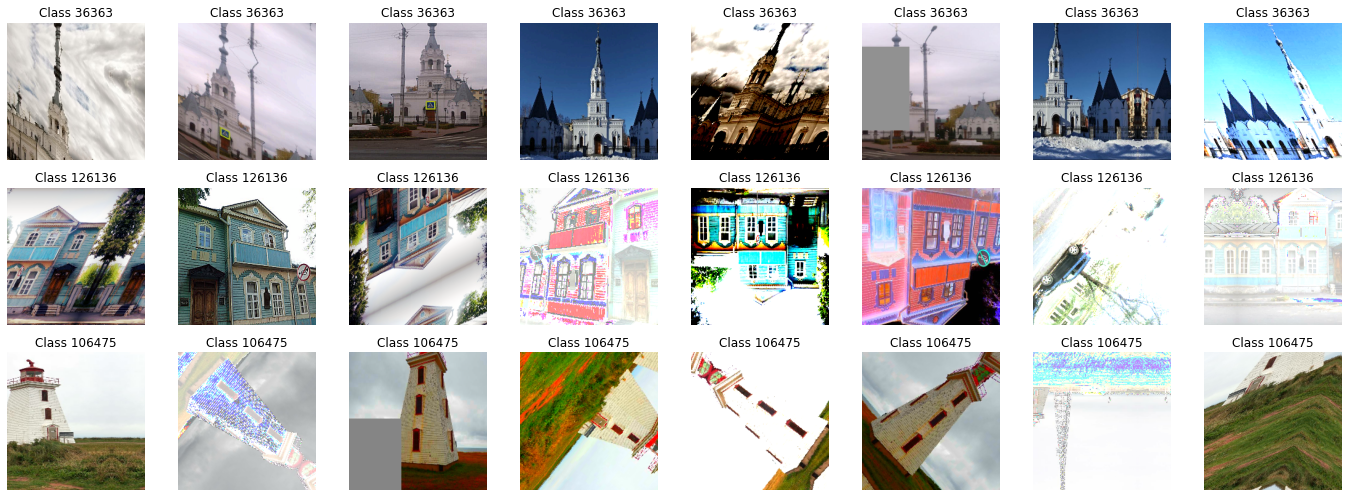

In [ ]:
IMG_SHAPE = (LARGER_IMG_SIZE, LARGER_IMG_SIZE, 3)
images = []
class_ids = []

ncols = num_examples_per_class
nrows = int(np.ceil(num_classes_per_batch * num_examples_per_class / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), squeeze=True)

num_plots = 0
for imgs, cids in train_ds.take(1):
    for ax, img, cid, _ in zip(axes.flat, imgs, cids, range(24)): # The range is a hack to exit the zip early
        max_val = float(tf.math.reduce_max(img))
        ax.imshow(img / max_val)
        ax.set_title(f"Class {cid}")
        ax.axis("off")
        num_plots += 1

for ax in axes.flat[num_plots:]:
    fig.delaxes(ax)

# Build and train

The following uses the EfficientNet as the backbone of the model and trains using `MutliSimilarityLoss()` for 10 epochs.

In [ ]:
from tensorflow.keras import layers

activation = "relu"
tf.keras.backend.clear_session()

with tf.distribute.MirroredStrategy().scope():
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
    inputs = layers.Input(shape=input_shape)
    x = backbone(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.1)(x)
    # x = layers.Dense(1024)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation(activation)(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    # x = layers.LayerNormalization(epsilon=1e-10)(x)
    x = tfsim.layers.MetricEmbedding(512)(x)
    loss = MultiSimilarityLoss(distance="cosine")
    # loss = TripletLoss(
    #     distance="cosine",
    #     positive_mining_strategy="easy",
    #     negative_mining_strategy="semi-hard",
    # )
    opt = tf.keras.optimizers.Adam(0.0005)

    model = tfsim.models.SimilarityModel(inputs, x)
    model.summary()
    model.compile(opt, loss=loss)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss", patience=10, restore_best_weights=True
    )
    tbc = tf.keras.callbacks.TensorBoard(
        log_dir=data_path / "models_owen" / "logs" / f"b0_single_512_adam_0005_drpout_1_multisimloss_{time.time()}",
        histogram_freq=1,
        update_freq=100,
    )
    mcp_train = tf.keras.callbacks.ModelCheckpoint(
        filepath= data_path / "models_owen" / "checkpoints" / f"b0_single_512_adam_0005_drpout_1_multisimloss_train_loss{time.time()}",
        monitor='loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
    mcp_val = tf.keras.callbacks.ModelCheckpoint(
        filepath= data_path / "models_owen" / "checkpoints" / f"b0_single_512_adam_0005_drpout_1_multisimloss_val_loss{time.time()}",
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
    
    model.load_weights(data_path / "models_owen" / "checkpoints" / "b0_single_512_adam_0005_drpout_1_multisimloss_1637744283.6702392")

    model.fit(train_ds, epochs=200, steps_per_epoch=1000, validation_data=validation_ds, validation_steps=100, callbacks=[early_stopping, tbc, mcp_train, mcp_val])

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)          

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200
1000/1000 [==============================] - 521s 469ms/step - loss: 2.1260 - val_loss: 2.2459
Epoch 2/200
1000/1000 [==============================] - 455s 455ms/step - loss: 2.1147 - val_loss: 2.2434
Epoch 3/200
1000/1000 [==============================] - 454s 454ms/step - loss: 2.1044 - val_loss: 2.2446
Epoch 4/200
1000/1000 [==============================] - 453s 453ms/step - loss: 2.1083 - val_loss: 2.2432
Epoch 5/200
1000/1000 [==============================] - 448s 448ms/step - loss: 2.1028 - val_loss: 2.2453
Epoch 6/200
1000/1000 [==============================] - 450s 450ms/step - loss: 2.1004 - val_loss: 2.2439
Epoch 7/200
1000/1000 [==============================] - 448s 448ms/step - loss: 2.1052 - val_loss: 2.2460
Epoch 8/200
1000/1000 [==============================] - 447s 447ms/step - loss: 2.0934 - val_loss: 2.2448
Epoch 9/200
1000/1000 [==============================] - 445s 445ms/step - loss: 2.0936 - val_loss: 2.2412
Epoch 10/200
1000/1000 [=============

In [ ]:
# # Using new tf_record sampling
# b0 -> gp2d -> dropout(0.1) -> den(1024) -> BN -> relu -> den(512) -> BN -> relu -> met_emb(512) -> MultiSim / Adam(0.001) @ 200 epochs - 129s 449ms/step - loss: 2.2759
# + b0 -> gp2d -> dropout(0.1) -> den(1024) -> BN -> relu -> den(512) -> BN -> relu -> met_emb(512) -> TripletLoss(easy, semi-hard) / Adam(0.001) @ 200 epochs - 130s 451ms/step - loss: 0.0595
# + b0 -> gp2d -> dropout(0.1) -> den(1024) -> BN -> relu -> den(512) -> BN -> relu -> layer_norm(epsilon=1e-10) -> TripletLoss(easy, semi-hard) / Adam(0.001) @ 200 epochs - 130s 449ms/step - loss: 0.0051

In [ ]:
# + B0 baseline emb 256 200 epochs - 123s 440ms/step - loss: 1.1197
# + batch norm emb 256 200 epochs - 125s 442ms/step - loss: 1.6548
# + dense relu emb 256 200 epochs - 124s 439ms/step - loss: 1.0671
# + dense bn relu emb 256 200 epochs - 124s 440ms/step - loss: 1.0504
# - 2x dense bn relu emb 256 200 epochs - 126s 441ms/step - loss: 1.0589
# - dense(512) bn relu emb 256 200 epochs - 125s 441ms/step - loss: 1.0606
# + dense(256) bn relu emb 256 lr 0.0005 200 epochs - 125s 440ms/step - loss: 1.0422
# - swish lr 0.001 - 123s 441ms/step - loss: 1.1085
# + gelu - 126s 443ms/step - loss: 1.0584
# - dense(512)- 125s 442ms/step - loss: 1.0603
# + add Dense(256) - 126s 443ms/step - loss: 1.0597
# - emb(512) - 127s 440ms/step - loss: 1.0611
# - pancake(512) - 127s 443ms/step - loss: 1.0802
# + add 10% dropout - 126s 442ms/step - loss: 1.0777
# - hourglass (512, 256, 512) - 126s 443ms/step - loss: 1.0783

In [ ]:
# ResNet50    emb 256 500/500  - 214s 359ms/step - loss: 1.1026
# B0 Baseline emb 256 500/500  - 266s 439ms/step - loss: 1.0846
# B0 Dense, LayerNorm, no MetricEmbedding emb 256 500/500  - 255s 438ms/step - loss: 13.7041

# Model Save and Load

In [22]:
model.save(data_path / "models_owen" / "B0_RandAug_MSLoss_512")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
model = tf.keras.models.load_model(data_path / "models_owen" / "checkpoints" / "b0_single_512_adam_0005_drpout_1_multisimloss_1637744283.6702392")

In [15]:
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)          

# Calibration

## Create Index and Query Splits

In [16]:
def plot_25(x, y):
    """Plot the first 25 images."""
    num_cols = num_rows = 5
    fig = plt.figure(figsize=(15.0, 15.0))
    grid = axes_grid1.ImageGrid(
        fig=fig,
        rect=111,
        nrows_ncols=(num_cols, num_rows),
        axes_pad=0.4,
    )

    for ax, im, cid in zip(grid, x, y):
        max_val = float(tf.math.reduce_max(im))
        ax.imshow(im / max_val)
        ax.set_title(f"Class {cid}")
        ax.axis("off")


def load_test_img(img_path):
    "Load image from disk and resize it"
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, expand_animations=False)
    img = tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(img)
    return img

In [17]:
QUERY_PER_CLASS = 2
query = defaultdict(int)
x_index, y_index = [], []
x_query, y_query = [], []

for idx in tqdm(range(NUM_TEST_IMGS)):
    img = load_test_img(x_test_img_path[idx])
    class_idx = y_test[idx]
    if query[class_idx] < QUERY_PER_CLASS:
        query[class_idx] += 1
        x_query.append(img)
        y_query.append(class_idx)
    else:
        x_index.append(img)
        y_index.append(class_idx)

x_index = np.array(x_index)
y_index = np.array(y_index)
x_query = np.array(x_query)
y_query = np.array(y_query)

  0%|          | 0/9375 [00:00<?, ?it/s]

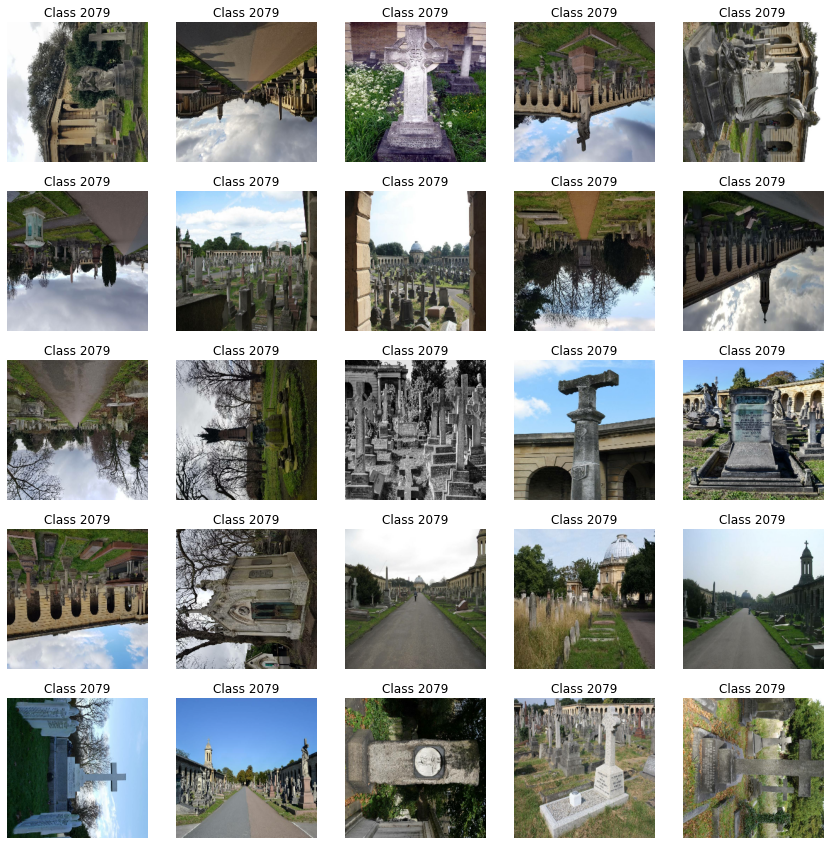

In [18]:
# Visualize the Validation Dataset
plot_25(x_index, y_index)

## Create Calibration Index

We can calibrate a distance threshold using a matching strategy and a calibration metric. Calibration requires creating an index, so here we load the x_index and y_index subset that we created when loading the training data.

In [19]:
model.reset_index()
model.index(x=x_index, y=y_index, data=x_index)

[Indexing 9191 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


## Find a Target Distance Threshold

Here we are searching for the optimal F1 score while using K=1 as our classifier. All matches at or below the calibrated threshold distance will be labeled as a Positive match between the query example and the label associated with the match result, while all matches above the threshold distance will be labeled as a Negative match.

Additionally, `model.calibrate()` returns a `CalibrationResults` object that can be used to plot and evaluate the metrics. The calibration object contains the following fields:

* "cutpoints": A Python dict mapping the cutpoint name to a dict containing the `ClassificationMetric` values associated with a particular distance threshold, e.g., "optimal" : {"acc": 0.90, "f1": 0.92}.
* "thresholds": A Python dict mapping `ClassificationMetric` names to a list containing the metric's value computed at each of the distance thresholds, e.g., {"f1": [0.99, 0.80], "distance": [0.0, 1.0]}.

In [ ]:
calibration = model.calibrate(x_query, y_query)


Performing NN search



Building NN list:   0%|          | 0/184 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/184 [00:00<?, ?it/s]


 name       value    distance    precision    recall        f1
-------  -------  ----------  -----------  --------  --------
optimal     0.81   0.0302651     0.684783         1  0.812903


In [ ]:
class_counts = {l: c for l, c in zip(*np.unique(y_index, return_counts=True))}
map100 = tfsim.retrieval_metrics.MapAtK(r=class_counts, k=100)
_ = model.evaluate_retrieval(x_query, y_query, retrieval_metrics=[map100])

|-Computing embeddings
|-Computing retrieval metrics

Performing NN search



Building NN list:   0%|          | 0/184 [00:00<?, ?it/s]


 [Summary]

metric       Value
--------  --------
map@100   0.170843


In [18]:
class_counts = {l: c for l, c in zip(*np.unique(y_index, return_counts=True))}
map100 = tfsim.retrieval_metrics.MapAtK(r=class_counts, k=100)
_ = model.evaluate_retrieval(x_query, y_query, retrieval_metrics=[map100])

|-Computing embeddings
|-Computing retrieval metrics

Performing NN search



Building NN list:   0%|          | 0/184 [00:00<?, ?it/s]


 [Summary]

metric       Value
--------  --------
map@100   0.163807


## Metrics Plots

The following plots show the change in the classification metrics over as the distance changes.

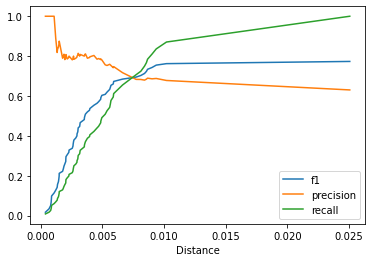

In [19]:
fig, ax = plt.subplots()
x = calibration.thresholds["distance"]
ax.plot(x, calibration.thresholds["f1"], label="f1")
ax.plot(x, calibration.thresholds["precision"], label="precision")
ax.plot(x, calibration.thresholds["recall"], label="recall")
ax.set_xlabel("Distance")
ax.legend()
plt.show()

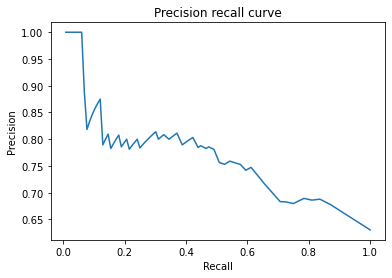

In [20]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

# Submission Code

## Index Data

We need to create the index in order to create the submission file. Tensorflow similarity enables users to batch add the index examples using the `model.index()` method. 

The following cell loads the index dataset img paths and then constructs batches of images and image IDs.

In [14]:
BATCH_SIZE = 64
test_path = data_path / "index"
index_imgs_path = list(test_path.glob("**/*.jpg"))
total_imgs = len(index_imgs_path)
# total_imgs = 1000  # remove to index the whole dataset 70k images

# reset the index
model.reset_index()

# indexing
pb = tqdm(total=total_imgs, desc="indexing images")
for idx in range(0, total_imgs, BATCH_SIZE):
    imgs = []
    img_ids = []

    # construct the batch
    for i in range(idx, min(idx + BATCH_SIZE, total_imgs)):
        img_path = index_imgs_path[i]
        imgs.append(load_img(str(img_path)))
        img_ids.append(img_path.stem)
        pb.update()

    # add the batch to the index
    model.index(np.array(imgs), data=img_ids, verbose=0)
pb.close()

indexing images:   0%|          | 0/76176 [00:00<?, ?it/s]

IndexError: list index out of range

## Match Test Images

Next we need to find the K nearest neighbors in the index for each image in the test dataset. The competition asks for the 100 nearest neighbors, but here we return the 10 nearest to keep the example simple.

Each query returns a list of `Lookup` object. For each list, we unpack the image ID stored in the `Lookup.data` field and then map the query image ID to the set of `Lookup` image IDs.

In [21]:
BATCH_SIZE = 64
k = 100  # competition assume k == 100 - using 10 for demo purpose.
results = defaultdict(list)
test_path = data_path / "test"
test_imgs_path = list(test_path.glob("**/*.jpg"))
total_imgs = len(test_imgs_path)
# total_imgs = 1000  # remove to index the whole dataset 70k images

# indexing
pb = tqdm(total=total_imgs, desc="matching images")
for idx in range(0, total_imgs, BATCH_SIZE):
    query_imgs = []
    query_img_ids = []

    # construct the batch
    for i in range(idx, min(idx + BATCH_SIZE, total_imgs)):
        img_path = test_imgs_path[i]
        query_imgs.append(load_img(str(img_path)))
        query_img_ids.append(img_path.stem)
        pb.update()

    # retrieve the KNN
    match_sets = model.lookup(np.array(query_imgs), verbose=0)

    # map the query image ID to the set of neighbor img IDs
    for query_img_id, match_set in zip(query_img_ids, match_sets):
        results[query_img_id] = [lookup.data for lookup in match_set]
pb.close()

matching images:   0%|          | 0/1129 [00:00<?, ?it/s]

## Check Data

The competition requires the data to be a two column CSV consisting of the query image ID and a space separated string representing the matching image IDs.

Here we print out the first 10 rows and verify the formatting.

In [22]:
rows = [[k, " ".join(v)] for k, v in results.items()]
print(tabulate(rows[:10], headers=["id", "images"], tablefmt="csv"))

id                images
----------------  ------------------------------------------------------------------------------------
8890929c27318d2b  300a62c4aa015b22 d85b4f2cf7b12cec b0602258b90a5e39 9f0b1b1eab40e062 1b478d6430674605
88ec81deb52a3df6  680fbbc181a7c2a8 33231d63685b9174 cdcec70c2727f7c8 985be0215cee945d 9d8559f72f4e7194
88471a39dac8ac43  bf7db1057fdee4df 482945f3b0d9f9e5 d2f0544c9c835cd1 94d4d33077703076 4f872c99b19ce1d0
88c00cecf7a76f74  a1c1a51d48b36152 02466f041e560dcc fcd456bb1f95b00a 8024788bbe87c72a eb3591d979728e9b
8821cb4b5330b189  59ca927b6e0c8a7a e027bb05b42425f1 39346bbb0908d063 ac73dba0d1478f0e 871885fa7b96ee72
8982b9bdab72d897  0abcae3d89059199 9a8c382fa43a3edd 1646d3c5bd59afa7 442f6d6d1373e8b5 ecba0f3f909420cf
89b12ae28e5f957a  72d951db7bd76d39 1b3522c7e7e7b4f7 9563c2f29fd2cab1 1b5b5a04c482fa9f f7a39778927c766f
8380babca9f46d53  5c9cae28694de262 39c00028b36c6d74 12a0c74f231dd1c7 84514415a1d25160 b76043e0cb228161
83f2225112c40910  df921f88a7b15dcd dd867e4962e7f

## Write Submission File

Finally, we write the results to disk.

In [23]:
with open(data_path / "submission.csv", "w+", newline="", encoding="utf-8") as out:
    writer = csv.writer(out)
    writer.writerow(["id", "images"])
    writer.writerows(rows)